In [1]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-10-31 16:37:32.048513: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 16:37:32.105854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 16:37:33.733245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [5]:
# dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])

In [1]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [2]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [3]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [4]:
wandb.init(project="PerceptNet_JaX",
           name="V2_Init",
           job_type="training",
           config=config,
           mode="online",
           )
config = config
config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin


BATCH_SIZE: 64
EPOCHS: 500
GDN_CLIPPING: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [10]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [11]:
#| export
class GDNGaussianStarRunning(nn.Module):
    """GDN variation where x^* is obtained as a running mean of the previously obtained values."""

    kernel_size: int
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    alpha: float = 2.
    epsilon: float = 1/2
    bias_init: Callable = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: x, jnp.quantile(inputs, q=0.95))
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (1,))
        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95))/2
        H = GaussianLayerGamma(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, bias_init=self.bias_init, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        denom = jnp.clip(H(inputs**self.alpha, train=train), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star_**self.alpha, train=train), a_min=1e-5)**self.epsilon)#/inputs_star_
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star
        
        return coef*inputs/denom

In [12]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FG = FreqGaussian()
        OG = OrientGaussian()
        outputs = GL(inputs**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FG(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        outputs = OG(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        denom = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)

        ## Coef
        coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        coef = FG(coef, fmean=fmean)
        coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = OG(coef, theta_mean=theta_mean) + bias
        coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # coef = inputs_star.value * coef
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)

In [13]:
from pickle import load
with open("gabor_x_star.pkl", "rb") as f:
    gabor_x_star = load(f)

In [14]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## bias = 0.1 / kernel = 0.5
        outputs = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=1.)(inputs)
        
        ## ATD Transformation
        outputs = JamesonHurvich()(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        ### A
        outputs0 = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=170.)(outputs[:,:,:,0:1])
        ### T
        outputs1 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,1:2])
        outputs1 = outputs1*(2*55/170)
        ### D
        outputs2 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,2:3])
        outputs2 = outputs2*(2*55/170)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## Apply CSF on Fourier
        outputs = CSFFourier(fs=64, norm_energy=True)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        ### A
        ### (384/4, 512/4, 1)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        outputs0 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.1]), inputs_star=0.3, outputs_star=None, fs=32)(outputs[:,:,:,0:1], **kwargs)
        ### T
        outputs1 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.06, outputs_star=None, fs=32)(outputs[:,:,:,1:2], **kwargs)
        ### D
        outputs2 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.08, outputs_star=None, fs=32)(outputs[:,:,:,2:3], **kwargs)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### A
        outputs0, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,0:1], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs0 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["A"])(outputs0, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### T
        outputs1, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,1:2], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs1 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["T"])(outputs1, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### D
        outputs2, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,2:3], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs2 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["D"])(outputs2, fmean=fmean, theta_mean=theta_mean, **kwargs)

        ## Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)
        
        return outputs

## Define the metrics with `clu`

In [15]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [16]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [17]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [18]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [19]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [20]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [21]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [22]:
import flax

In [23]:
def check_trainable(path):
    return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [5]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDNStarSign_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    GDNStarSign_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    GDNStarDisplacement_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    GDNStarDisplacement_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CSFFourier_0: {
        alpha_achrom: 'non_trainable',
        alpha_chrom_rg: 'non_trainable',
        alpha_chrom_yb: 'non_trainable',
        beta_achrom: 'trainable',
        beta_chrom: 'trainable',
        fm: 'trainable',
        s: 'trainable',
    },
    GDNGaussianStarRunning_0: {
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'non_trainable',
            bias: 'trainable',
        },
    },
    GDNGaussianStarRunning_1: {
        Gaussi

In [25]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [26]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [27]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [6]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

724

In [29]:
wandb.run.summary["trainable_parameters"] = param_count

In [30]:
state = state.replace(params=unfreeze(state.params))

## DN 0
state.params["GDNStarSign_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarSign_0"]["Conv_0"]["bias"])*0.1
state.params["GDNStarSign_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarSign_0"]["Conv_0"]["kernel"])*0.5

## DN J&H
state.params["GDNStarSign_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarSign_1"]["Conv_0"]["bias"])*30.**2
state.params["GDNStarSign_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarSign_1"]["Conv_0"]["kernel"])*0.5

state.params["GDNStarDisplacement_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarDisplacement_0"]["Conv_0"]["bias"])*10.**2
state.params["GDNStarDisplacement_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarDisplacement_0"]["Conv_0"]["kernel"])*0.5

state.params["GDNStarDisplacement_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDNStarDisplacement_1"]["Conv_0"]["bias"])*10.**2
state.params["GDNStarDisplacement_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDNStarDisplacement_1"]["Conv_0"]["kernel"])*0.5

state.params["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)

state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
state.params["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
state.params["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)

state.params["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"])*20
state.params["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"])*20
state.params["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"])*20

state.params["GDNSpatioFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["GDNSpatioFreqOrient_1"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["GDNSpatioFreqOrient_2"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)


state = state.replace(params=freeze(state.params))

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [31]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [32]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [33]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

2023-10-31 16:38:15.448732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1632]
	 [[{{node Placeholder/_0}}]]


In [34]:
from functools import partial

In [35]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [7]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 24.1 s, sys: 4.13 s, total: 28.2 s
Wall time: 19.1 s


(64, 96, 128, 192)

In [37]:
%%time
s1 = train_step(state, batch)

CPU times: user 3min 31s, sys: 8.21 s, total: 3min 39s
Wall time: 2min 38s


In [38]:
# jax.config.update("jax_debug_nans", True)

In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

<class 'ValueError'>: autodetected range of [nan, nan] is not finite

Epoch 0 -> [Train] Loss: -0.46230649948120117 [Val] Loss: -0.6404291391372681
Epoch 1 -> [Train] Loss: -0.5066695809364319 [Val] Loss: -0.6715699434280396
Epoch 2 -> [Train] Loss: -0.5312695503234863 [Val] Loss: -0.6914645433425903
Epoch 3 -> [Train] Loss: -0.5660589337348938 [Val] Loss: -0.71083003282547
Epoch 4 -> [Train] Loss: -0.5968101620674133 [Val] Loss: -0.7331307530403137
Epoch 5 -> [Train] Loss: -0.6504687070846558 [Val] Loss: -0.7602219581604004
Epoch 6 -> [Train] Loss: -0.6882992386817932 [Val] Loss: -0.7862057089805603
Epoch 7 -> [Train] Loss: -0.7348223924636841 [Val] Loss: -0.8190333843231201
Epoch 8 -> [Train] Loss: -0.759041965007782 [Val] Loss: -0.8245800733566284
Epoch 9 -> [Train] Loss: -0.7554469704627991 [Val] Loss: -0.8192509412765503
Epoch 10 -> [Train] Loss: -0.7640332579612732 [Val] Loss: -0.8232132792472839
Epoch 11 -> [Train] Loss: -0.7599337697029114 [Val] Loss: -0.8247334957122803
Epoch 12 -> [Train] Loss: -0.7729227542877197 [Val] Loss: -0.826416313648223

Save the final model as well in case we want to keep training from it or whatever:

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()

epoch,452
train_loss,-0.89585
trainable_parameters,724
val_loss,-0.89161


In [41]:
import matplotlib.pyplot as plt

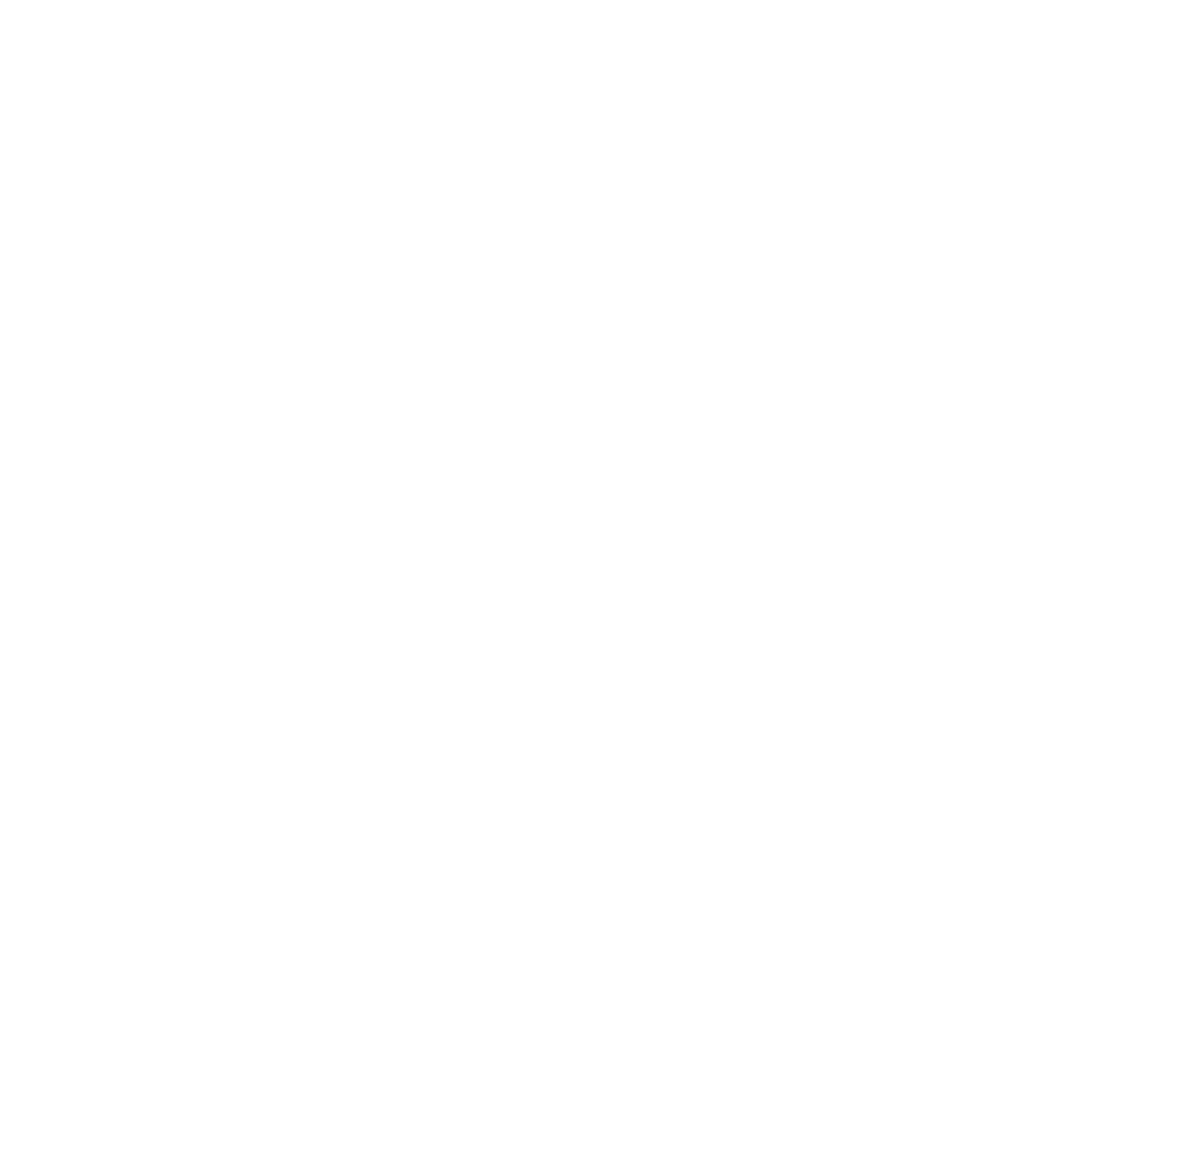

In [42]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerLogSigma__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()